# Advanced:  Bert-Based Model for Dialogue Act Tagging

In the last section we want to use BERT and leverage contextual word embeddings, following on from the last lab you've 
just done. This is an advanced part of the assignment and worth 10 marks (20%) in total. You could use your BERT-based text classifier here (instead of the CNN utterance-level classifier) and see if a pre-trained BERT language model helps. The domain difference from conversational data is one possible downside to using BERT. Explore some techniques to efficiently transfer the knowledge from conversational data and to improve model performance on DA tagging.

In [2]:
!pip install -r bert_requirement.txt > /dev/null

ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [0]:
import os, glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools, random
from collections import Counter

# Data

Unzip swda.zip and drop all the extra columns keep text and tag and create three datasets in train.csv, val.csv and test.csv 

In [0]:
!unzip swda.zip > /dev/null

In [0]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)
result.to_csv('swda_all_data.csv',index=False)

In [6]:
reduced_df = result[['act_tag','text']]
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))
dummies = pd.get_dummies(reduced_df[["act_tag"]])
res = pd.concat([reduced_df, dummies], axis=1)
# res = res.drop(["act_tag"], axis=1)

res['tag_arg_max'] = res.apply(lambda x: np.argmax(np.asarray(x[2:],dtype=np.float32)),axis=1)
one_hot_encoding_dict = {}
for row in res.values:
    one_hot_encoding_dict[row[0]] = row[-1]
res = res.drop(columns=['act_tag','tag_arg_max'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
train = res[0:140000]
val = res[140000:167704]
test = res[167704:]
train.to_csv("train.csv",index=False)
val.to_csv("val.csv",index=False)
test.to_csv("test.csv",index=False)
train = pd.read_csv("train.csv")
valid = pd.read_csv("val.csv")
test = pd.read_csv("test.csv")

In [0]:
# train = train.append(valid).reset_index(drop=True)

In [8]:
train.shape,test.shape,val.shape

((140000, 44), (55902, 44), (27704, 44))

# Get Pre-trained BERT model 

We would be using `uncased_L-12_H-768_A-12` version of BERT which has 12 layers and returns 768 hidden parameters.

In [9]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-04-28 03:42:08--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  76.5MB/s    in 6.6s    

2020-04-28 03:42:14 (59.3 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [10]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [0]:
os.makedirs("model")

In [0]:
!mv uncased_L-12_H-768_A-12/ model

In [0]:
bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing of Data

Preprocessing the Data as BERT would expect.

In [0]:
class ProcessData:
    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.max_seq_len = 0
        self.tokenizer = tokenizer

        self.classes = classes    
        ((self.train_x, self.train_y), (self.test_x, self.test_y), (self.val_x, self.val_y)) = map(self.convert_text_to_examples, [train, test, val])

        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        print("Max Seq Len", self.max_seq_len)
        self.train_x, self.test_x, self.val_x = map(self.add_pad, [self.train_x, self.test_x, self.val_x])

    def convert_text_to_examples(self, df):
        x, y = [], []
    
        for _, row in tqdm(df.iterrows()):
            text, label = row[0], np.asarray(row[1:],dtype=np.float32)
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(label)

        return np.array(x), np.array(y)

    def add_pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

In [0]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [16]:
classes = 43

data = ProcessData(train, test, tokenizer, classes, max_seq_len=128)

140000it [00:57, 2434.57it/s]
55902it [00:23, 2405.45it/s]
27704it [00:11, 2442.06it/s]


Max Seq Len 128


In [0]:
from tensorflow.keras.layers import Lambda, Input, LSTM, RepeatVector, Dense, Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding, Reshape, concatenate, Conv2D, BatchNormalization, MaxPool2D, Flatten

HIDDEN_SIZE = 43
drop = 0.2
# https://github.com/kpe/bert-for-tf2
def create_model(max_seq_len, bert_ckpt_file):
    """
    Use the pre-trained BERT model over LSTM
    """
    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    input_ids = Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    # BERT out
    bert_output = bert(input_ids)
    # to get the output dmin of form (none,128,768) --> (none,768) 
    lmd_out = Lambda(lambda seq: seq[:, 0, :])(bert_output)
    dense_1 = Dense(units=768, activation="tanh")(lmd_out)
    dropout_1 = Dropout(0.5)(dense_1)


    # LSTM expect (batch_size, timesteps, features) or (num_samples, timesteps, channels) 
    # using BERT output (none,128,768) to distribute over time(128) for LSTM
    timexx = TimeDistributed(Dense(max_seq_len))(bert_output)
    # Bidirectional 1
    b1 = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True))(timexx)
    # Bidirectional 2
    b2 = Bidirectional(LSTM(HIDDEN_SIZE))(b1)
    # Dense layer (dense_2)
    dense_2 = Dense(HIDDEN_SIZE)(b2)
    # dropout_2
    dropout_2 = Dropout(drop)(dense_2)


    # concatenate 2 final layers
    y = concatenate([dropout_1, dropout_2],axis = -1)
    # output
    out = Dense(HIDDEN_SIZE)(y)
    out = Activation('sigmoid')(out)


    model = Model(inputs=input_ids, outputs=out)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)
        
    return model

In [18]:
model = create_model(data.max_seq_len, bert_ckpt_file)
model.summary()

Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd669e6d7f0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
_________________________________________________

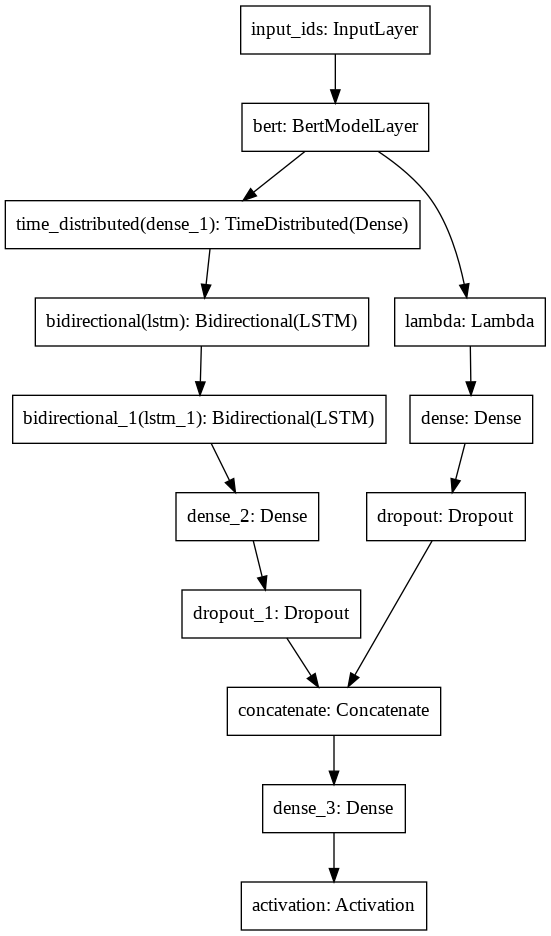

In [19]:
plot_model(model, to_file='model.png')

From the above figure, we can understand that, the contextual information is being processed by BERT model and is being passed onto by the BiLSTM layers via timedistributed as LSTM only expect (batch_size, timesteps, features)  or (num_samples, timesteps, channels). The LSTM layers carry out the classification task and results are passed though sigmoid activation layer though which each class is decided.

## Training

In [0]:
def train_test_input_fn(batch_size=256):
    # covert data into tensor datasets

    # Convert the inputs to a Dataset.
    dataset_train = tf.data.Dataset.from_tensor_slices((data.train_x,data.train_y))
    dataset_test = tf.data.Dataset.from_tensor_slices((data.test_x,data.test_y))
    dataset_val = tf.data.Dataset.from_tensor_slices((data.val_x,data.val_y))
    # Shuffle, repeat, and batch the examples.
    dataset_train = dataset_train.cache()
    dataset_train = dataset_train.shuffle(1000, reshuffle_each_iteration=True)
    dataset_train = dataset_train.repeat()
    dataset_train = dataset_train.batch(batch_size, drop_remainder=True)
    # dataset_test = dataset_test.cache()
    # dataset_test = dataset_test.shuffle(1000, reshuffle_each_iteration=True)
    # dataset_test = dataset_test.repeat()
    dataset_test = dataset_test.batch(batch_size, drop_remainder=True)
    dataset_val = dataset_val.cache()
    dataset_val = dataset_val.shuffle(1000, reshuffle_each_iteration=True)
    dataset_val = dataset_val.repeat()
    dataset_val = dataset_val.batch(batch_size, drop_remainder=True)
    # Return the dataset.
    return dataset_train,dataset_test,dataset_val


In [16]:
try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_ADDRESS = 'grpc://' + device_name
    print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
    print('TPU not found')

Found TPU at: grpc://10.125.46.186:8470


In [17]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)


INFO:tensorflow:Initializing the TPU system: 10.125.46.186:8470


INFO:tensorflow:Initializing the TPU system: 10.125.46.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [18]:
with strategy.scope():
  model = create_model(data.max_seq_len, bert_ckpt_file)
  model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'], )
# setting batch size to 121 as it perfecty divides test data length
train_dataset, test_dataset, val_dataset = train_test_input_fn(121)

model.fit(train_dataset,
          epochs=10,
          steps_per_epoch = 1157, #len(train)/121
          validation_data=val_dataset,
          validation_steps=228 # #len(val)/121
          )


Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f84ee868320> (prefix:bert_1). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Train for 1157 steps, validate for 228 steps
Epoch 1/10
1157/1157 [==============================] - 218s 188ms/step - loss: 1.5118 - accuracy: 0.5798 - val_loss: 1.0129 - val_accuracy: 0.7006
Epoch 2/10
1157/1157 [==============================] - 165s 143ms/step - loss: 0.9156 - accuracy: 0.7315 - val_loss: 0.9302 - val_accuracy: 0.7213
Epoch 3/10
1157/11

In [32]:
score = model.evaluate(test_dataset,steps=462) #len(test)/121

462/462 [==============================] - 34s 73ms/step - loss: 0.9278 - accuracy: 0.7227


In [25]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 72.47933745384216


The overall accuracy is 73%

## Evaluation

In [0]:
# Generate predictions for the test data
pred_test = model.predict(test_dataset,steps=462) # 55902/121

In [35]:
y_test = [np.asarray(row[1:],dtype=np.float32) for row in test.values]
pred_1d = np.argmax(pred_test, axis=1)
test_1d = np.argmax(y_test, axis=1)

print("Predicted Class: ", Counter(list(pred_1d)))
print("Test Class: ", Counter(list(test_1d)))
print("One hot encoded dict class: ", one_hot_encoding_dict)

Predicted Class:  Counter({38: 21367, 11: 9232, 39: 5643, 1: 5307, 6: 4071, 0: 3313, 36: 1167, 13: 1129, 42: 941, 34: 576, 27: 553, 16: 328, 20: 308, 24: 305, 8: 260, 17: 198, 15: 166, 32: 151, 31: 134, 21: 99, 37: 92, 4: 90, 5: 81, 18: 65, 33: 65, 23: 52, 22: 47, 26: 32, 12: 28, 19: 27, 3: 19, 2: 14, 40: 10, 14: 9, 25: 7, 30: 6, 41: 6, 7: 4})
Test Class:  Counter({38: 18651, 11: 9568, 39: 7738, 1: 4579, 0: 3928, 6: 2327, 36: 1166, 42: 965, 13: 935, 29: 715, 34: 530, 20: 490, 21: 434, 24: 385, 27: 362, 37: 291, 15: 265, 17: 237, 5: 237, 2: 229, 25: 203, 16: 200, 8: 182, 31: 178, 12: 164, 32: 144, 4: 132, 18: 110, 26: 74, 9: 70, 33: 62, 22: 53, 28: 48, 3: 47, 14: 34, 30: 31, 40: 28, 23: 27, 7: 26, 19: 20, 41: 13, 10: 12, 35: 12})
One hot encoded dict class:  {'fp': 22, 'b': 11, 'sv': 39, 'aa': 6, 'sd': 38, 'x': 42, 'qy': 36, 'na': 25, 'bk': 17, 'b^m': 12, '%': 0, 'ad': 8, 'qw': 34, 't1': 40, 'qw^d': 35, '+': 1, 'qh': 31, 'h': 24, 'qy^d': 37, '^2': 2, 'bf': 15, 'ar': 9, 'ng': 26, 'ba': 1

In [36]:
len(pred_1d),len(test_1d)

(55902, 55902)

In [0]:
classes = []
act_seq = {j:i for i,j in one_hot_encoding_dict.items()}
for i in range(len(act_seq)):
    classes.append(act_seq[i])

In [0]:
# Build the confusion matrix off these predictions
# matrix = confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1))
cnf_matrix = confusion_matrix(test_1d,pred_1d)

Text(0.5, 240.76499999999993, 'Predicted label')

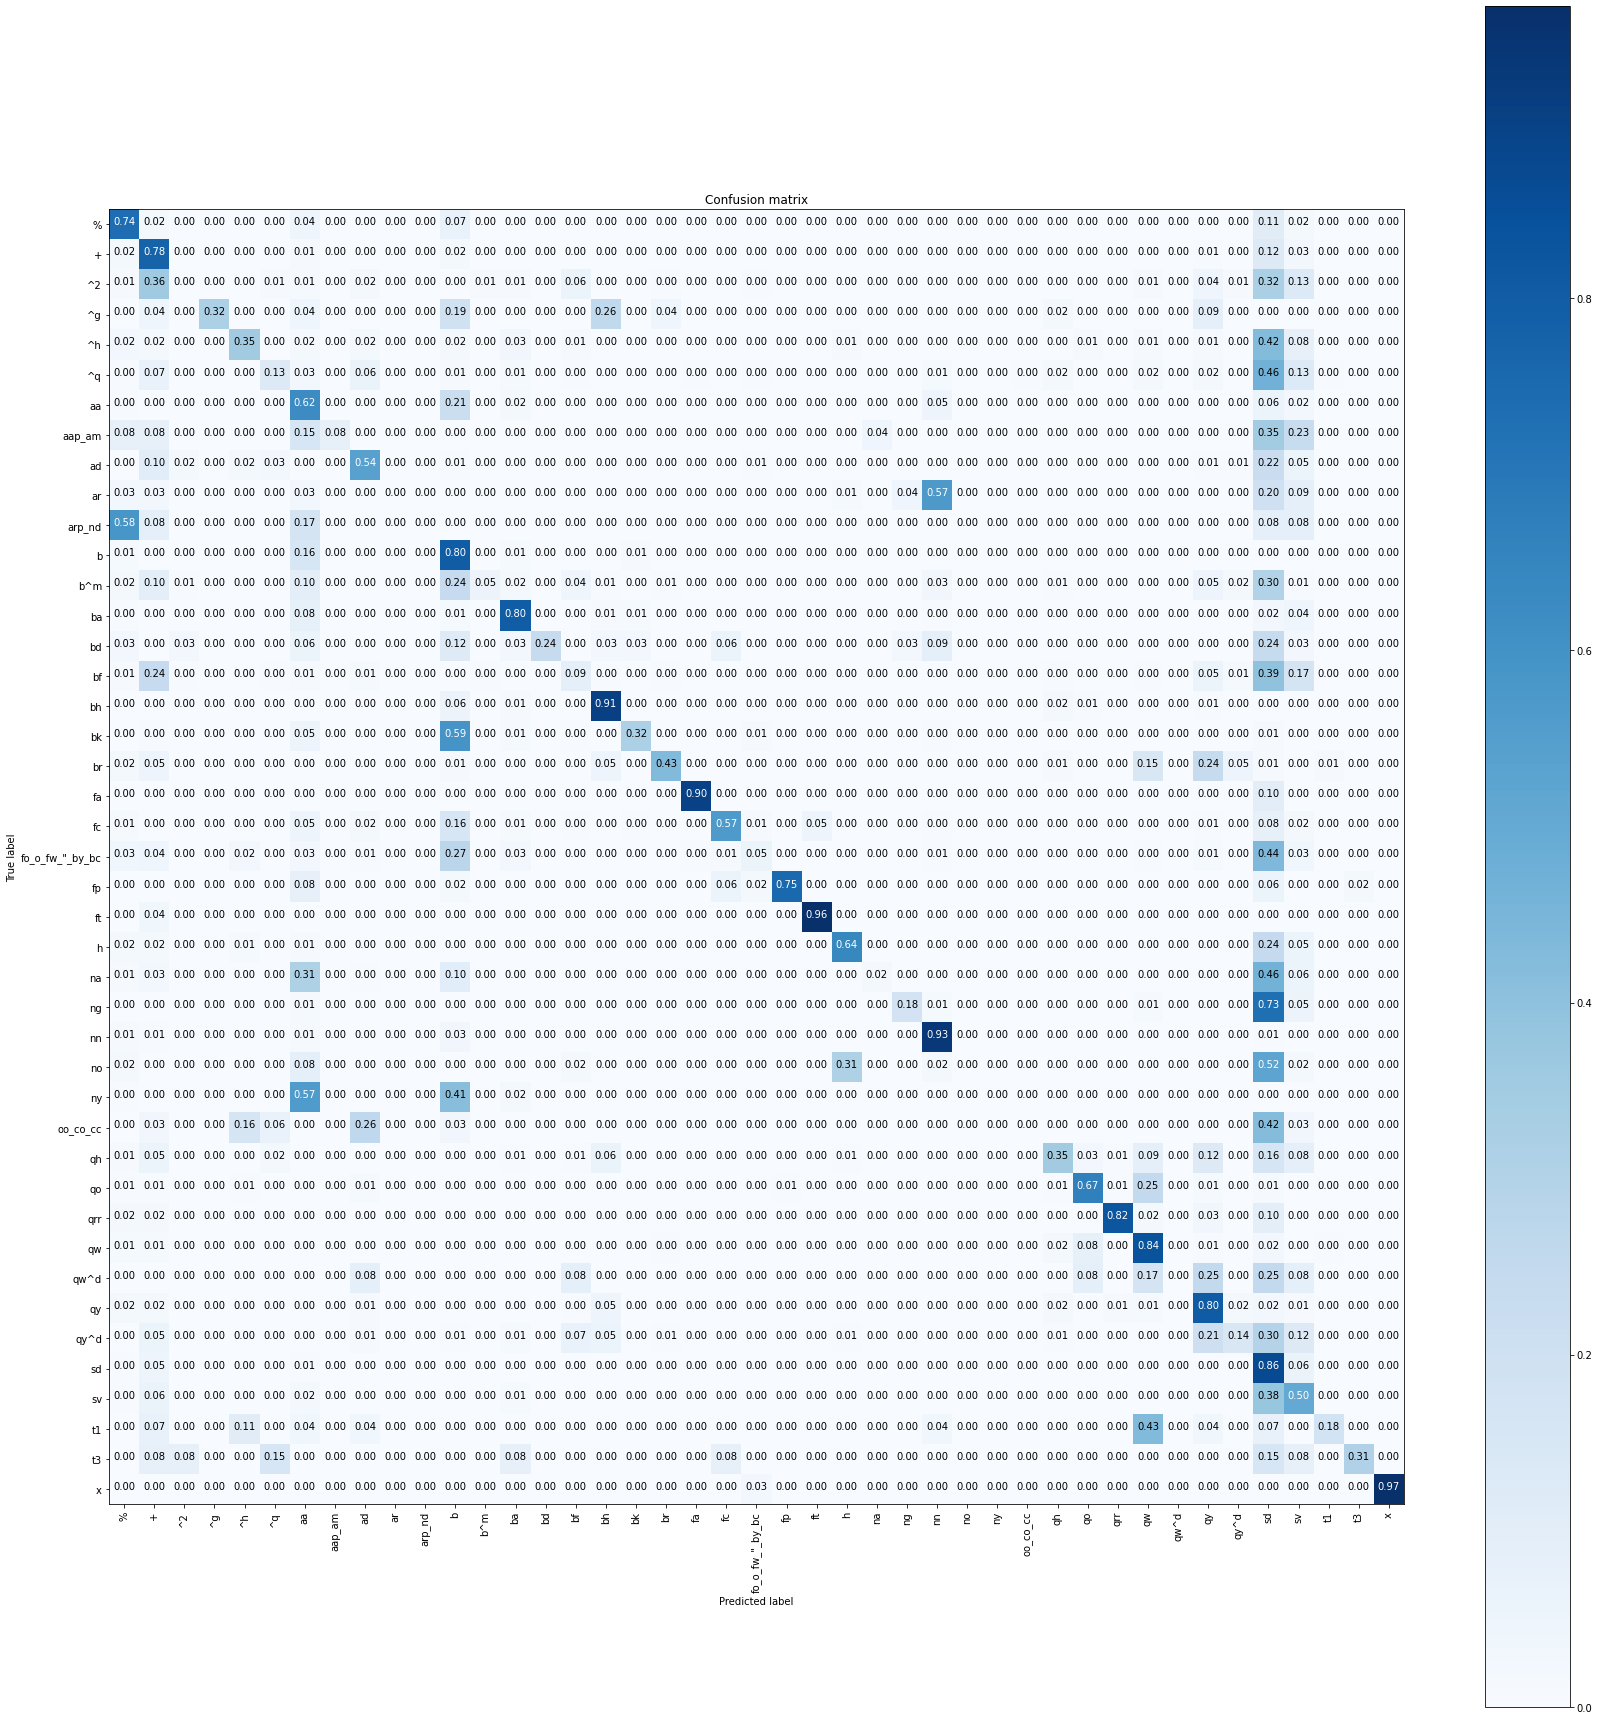

In [46]:
# Plot normalized confusion matrix
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
# https://stackoverflow.com/a/50977153/4414156
fig = plt.figure()
fig.set_size_inches(24, 24, forward=True)
plt.imshow(np.nan_to_num(cnf_matrix) , interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j], '.2f'),
                horizontalalignment="center",
                color="white" if cnf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Minority Class

In [40]:
# Calculate Accuracies for "br" and "bf"
for i,j in zip(classes,cnf_matrix.diagonal()):
    if i=='br' or i=='bf':
        print(i,j)

bf 0.13855421686746988
br 0.7230769230769231


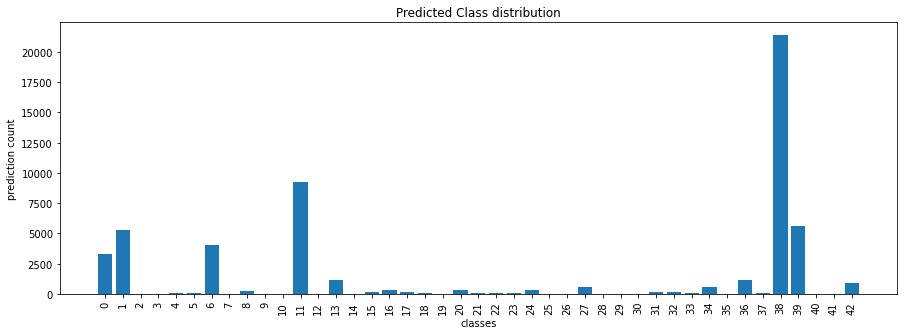

Randomly picking few Testing instances :  [43680, 52946, 25149]
Randomly picking few Testing instances :  [5046, 5740, 14108]


row                                               text true_y pred_y
0  39683  {C and } I think [ they really +   <lipsmack> ...     sv      %
1  11471                                 {F Oh } my gosh. /     ba     ba
2  44566                      It's interesting, isn't it? /     qy     qy
3   4197                                              Take,     fc     fc
4  21049         that was part of Skip Bayless' argument. /     sd     sd
5   3452               It had held onto a small portion,  /     sd     sd

In [42]:
# br_class_test,br_class_pred
lists = sorted(Counter(list(pred_1d)).items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
ind = np.arange(43)
fig = plt.figure()
fig.set_size_inches(15, 5, forward=True)
plt.title("Predicted Class distribution")
plt.xticks(ind, (range(43)), rotation=90)
plt.xlabel("classes")
plt.ylabel("prediction count")
plt.bar(x,y)
plt.show()
minority_classes = [ k for k, v in sorted(Counter(list(pred_1d)).items(), key=lambda item: item[1])][-6:-4] 
minority_classes.sort()
analysis = []
row_indices = []
for i in minority_classes:
    br_class_test = set(np.where(test_1d == i)[0].tolist())
    br_class_pred = set(np.where(pred_1d == i)[0].tolist())
    row_ind = br_class_test.intersection(br_class_pred)
    row_ind = random.sample(list(row_ind), 3)
    row_indices.extend(row_ind)
    print("Randomly picking few Testing instances : ", list(row_ind))
    if list(row_ind):
        for j in list(row_ind):
            analysis.append([j,reduced_df.iloc[train.shape[0]+j].text,reduced_df.iloc[train.shape[0]+j].act_tag,act_seq[pred_1d[j]]])

analysis = pd.DataFrame(analysis,columns=['row','text','true_y','pred_y'])
analysis

From the confusion matrix we can see that the BERT has performed well on minority class as well as majority class. It has acheived an overall accuracy of 73% and minority class br 46% and bf 8%. 

We can also see from the overall accuracy score and minority class accuracy scores that BERT has given meaningful contextual information for LSTM to get trained properly. 

The last table presents some of the errors encountered during this Model evaluation. We see some of the minority class being miss-classified as usual but this trend is less than in other models such as "sv" but other classes are well classifed. 